# Visão Computacional e Deep Learning para Sensoriamento Remoto com Python


# Capítulo 10 - Segmentação Semântica de Imagens

## Métodos de Deep Learning de Segmentação Semântica

Até agora, você viu a classificação de imagens, em que a tarefa da rede é atribuir um rótulo ou classe a uma imagem de entrada. No entanto, suponha que você queira saber onde um objeto está localizado na imagem, a forma desse objeto, qual pixel pertence a qual objeto etc. Nesse caso, você desejará segmentar a imagem, ou seja, para cada pixel da imagem é dado um rótulo. Assim, a tarefa da segmentação de imagens é treinar uma rede neural para produzir uma máscara da imagem em pixels. Isso ajuda a entender a imagem em um nível muito mais baixo, isto é, o nível de pixel. A segmentação de imagens tem muitas aplicações em imagens médicas, carros autônomos e imagens de satélite, para citar alguns.

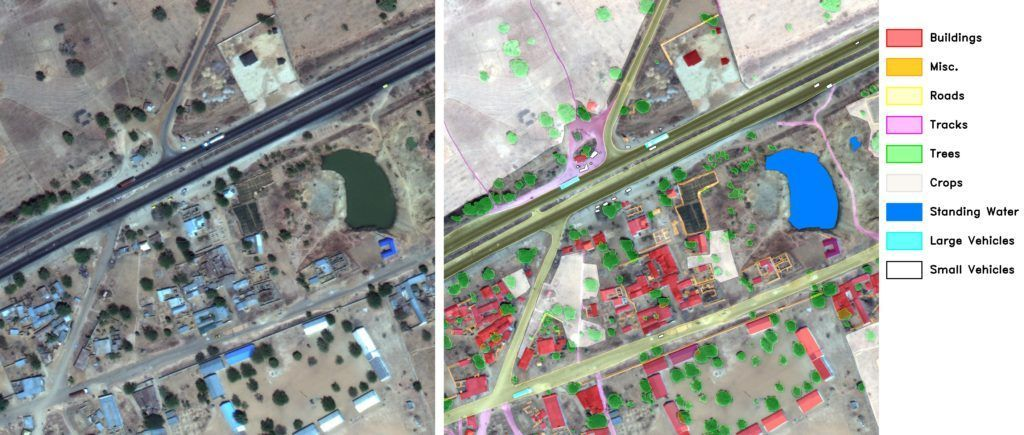

Mais precisamente, a segmentação semântica de imagens é a tarefa de rotular cada pixel da imagem em um conjunto predefinido de classes. Por exemplo, vários objetos como carros, árvores, pessoas, sinais de trânsito etc. podem ser usados como classes para segmentação semântica de imagens. Portanto, a tarefa é pegar uma imagem (RGB ou escala de cinza) e produzir uma matriz W x H x 1, onde W e H representam a largura e a altura da imagem, respectivamente. Cada célula nesta matriz conteria os IDs de classe previstos para cada pixel na imagem.

### Classificação de imagens X Segmentação Semântica

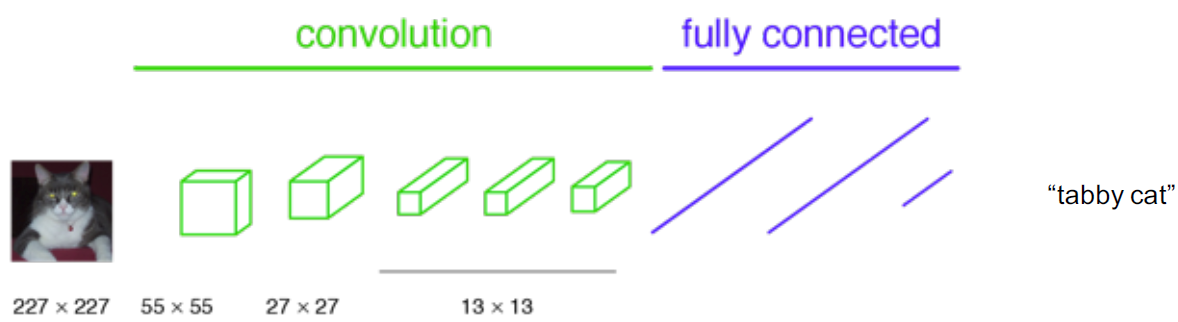

Quando se trata de segmentação semântica, geralmente não exigimos uma camada totalmente conectada no final porque nosso objetivo não é prever o rótulo de classe da imagem.

Na segmentação semântica, nosso objetivo é extrair recursos antes de usá-los para separar a imagem em vários segmentos.

No entanto, o problema com as redes convolucionais é que o tamanho da imagem é reduzido à medida que passa pela rede devido às camadas de pooling máximo.

Para separar eficientemente a imagem em vários segmentos, precisamos aumentar a resolução usando uma técnica de interpolação, que é obtida usando camadas deconvolucionais.

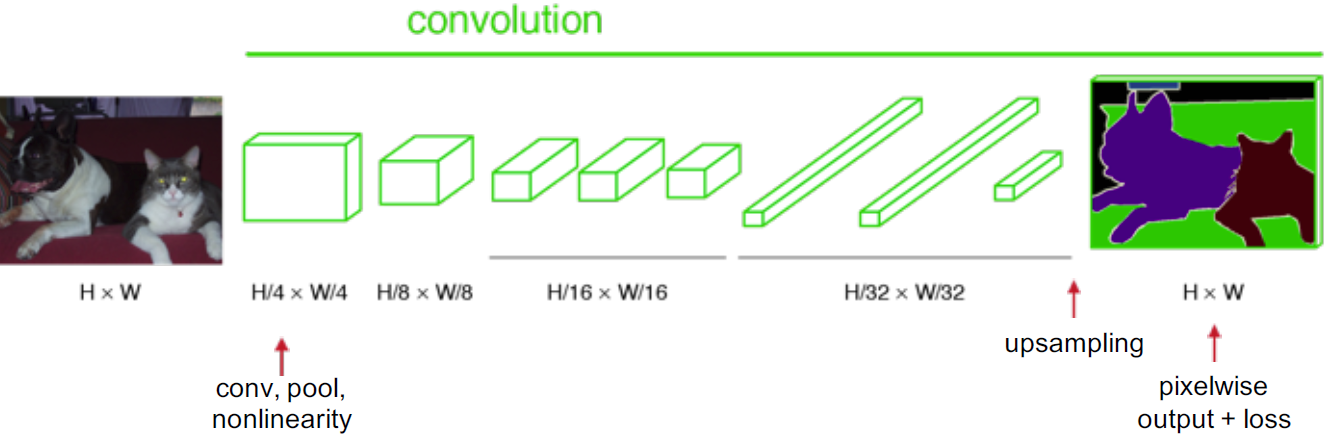

### Labels na Segmentação Semântica

No Deep learning, expressamos rótulos de classe categórica como vetores codificados one-hot. Da mesma forma, na segmentação semântica, podemos expressar a matriz de saída usando um esquema de codificação one-hot essencialmente criando um canal para cada rótulo de classe e marcando as células por 1 que contêm o pixel da classe correspondente e marcando as células restantes por 0.

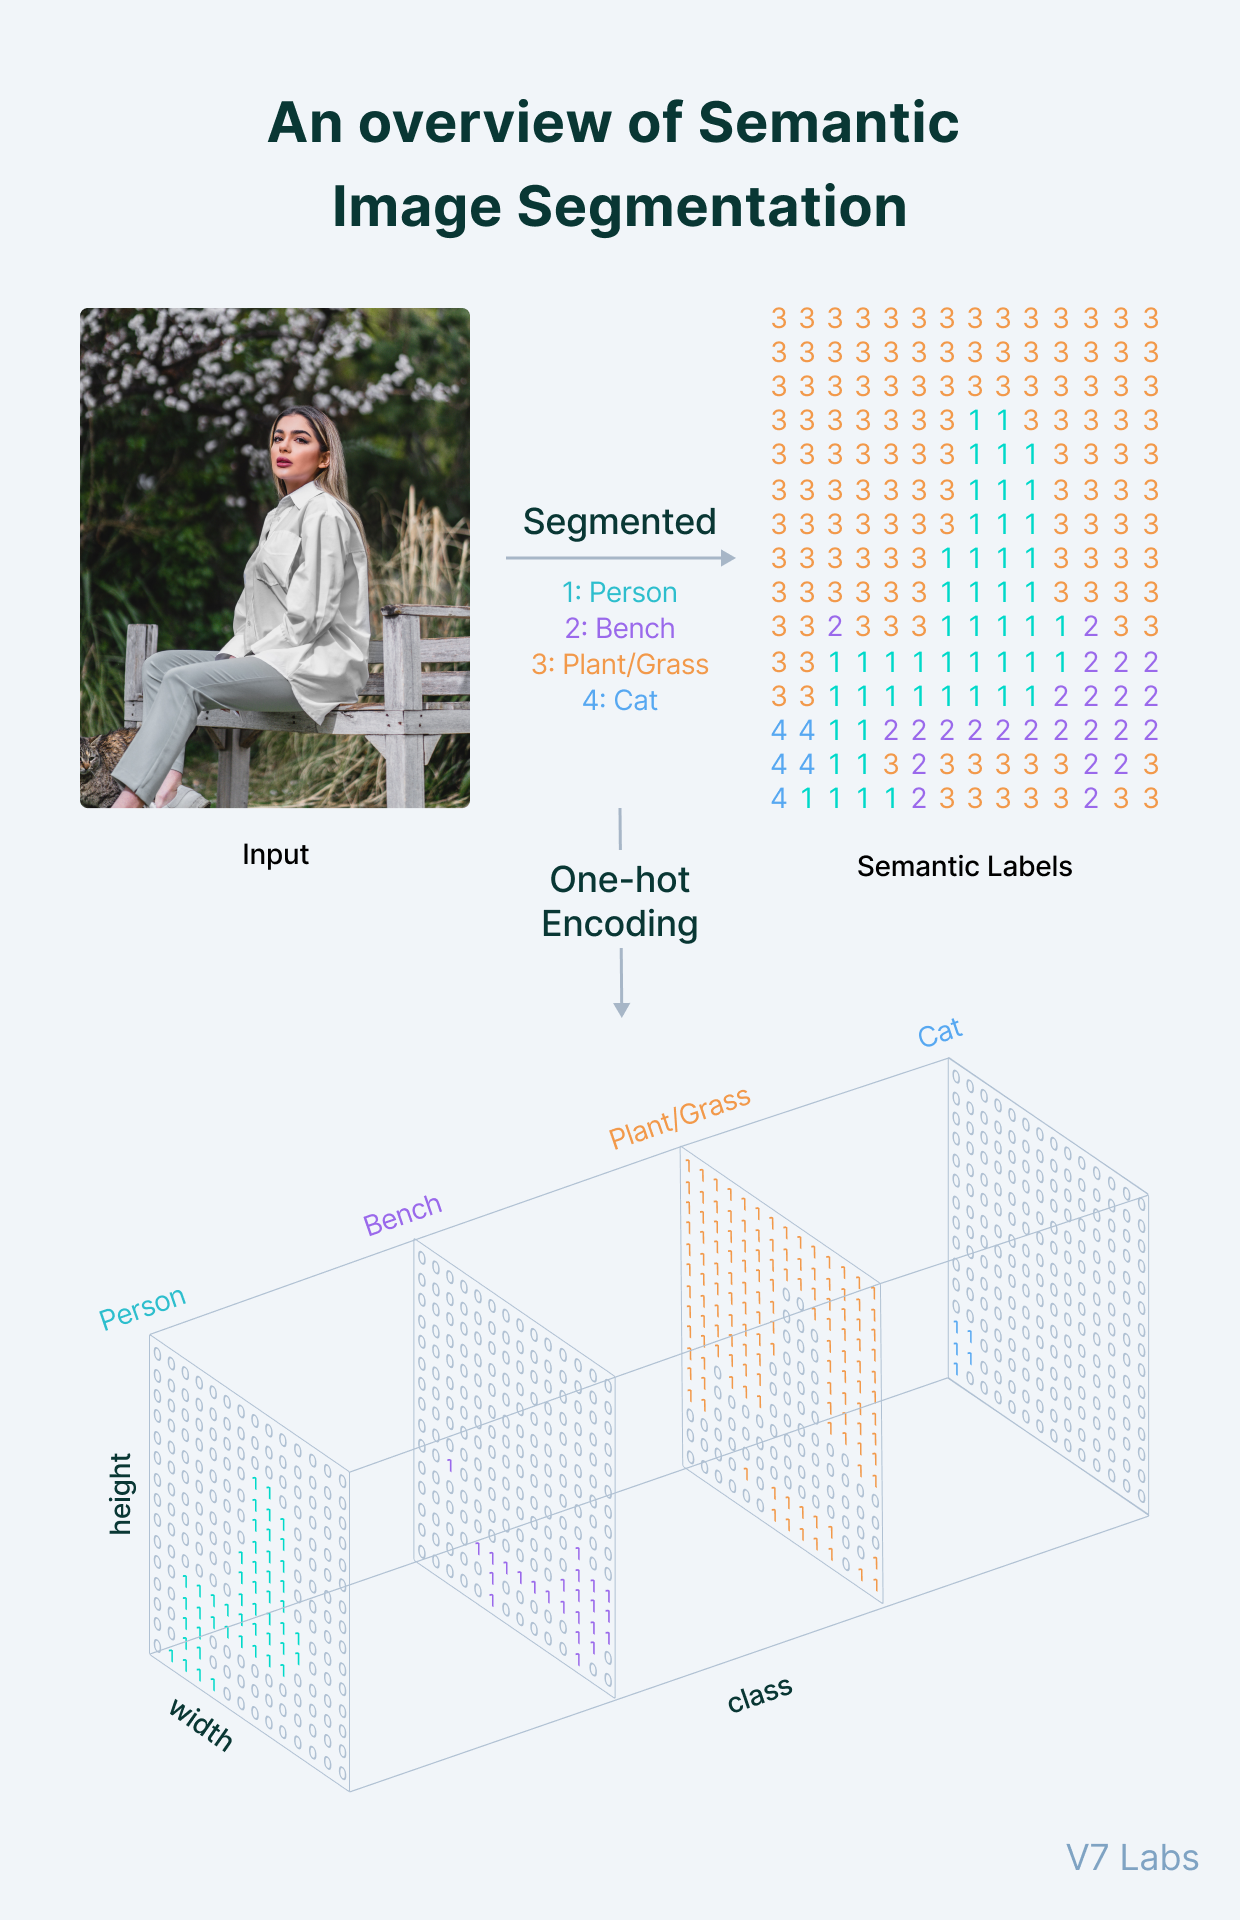

##Construíndo uma Arquitetura de Segmentação Semântica

Como outras tarefas de visão computacional, usar uma CNN para segmentação semântica seria a escolha óbvia. Ao usar CNN para segmentação semântica, a saída seria uma imagem com a mesma resolução da entrada, diferentemente de um vetor de comprimento fixo no caso de classificação de imagens.


Uma abordagem ingênua para a construção de uma arquitetura de rede neural para esta tarefa é simplesmente empilhar várias camadas convolucionais (com o mesmo preenchimento para preservar as dimensões) e gerar um mapa de segmentação final. Isso aprende diretamente um mapeamento da imagem de entrada para sua segmentação correspondente por meio da transformação sucessiva de mapeamentos de recursos; no entanto, é bastante custoso computacionalmente preservar a resolução total em toda a rede.

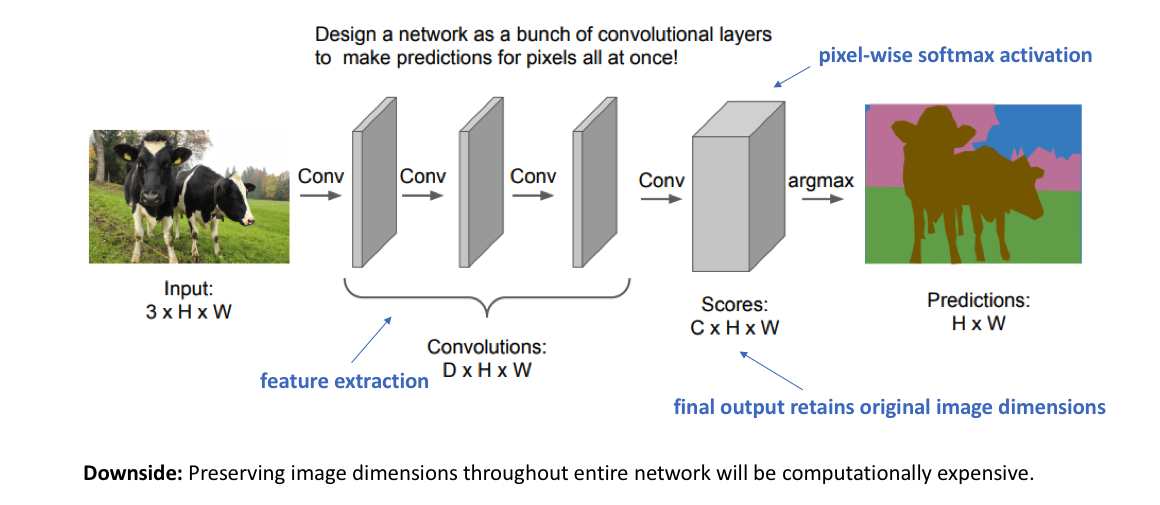



Lembre-se de que, para redes convolucionais profundas, as camadas anteriores tendem a aprender conceitos de baixo nível, enquanto as camadas posteriores desenvolvem mais mapeamentos de recursos de alto nível (e especializados). Para manter a expressividade, normalmente precisamos aumentar o número de mapas de recursos (canais) à medida que nos aprofundamos na rede.

Isso não representa necessariamente um problema para a tarefa de classificação de imagens, pois para essa tarefa nos preocupamos apenas com o que a imagem contém (e não onde ela está localizada). Assim, poderíamos aliviar a carga computacional diminuindo periodicamente a amostragem de nossos mapas de recursos por meio de pooling ou convoluções strided (ou seja, comprimindo a resolução espacial) sem preocupação. No entanto, para segmentação de imagens, gostaríamos que nosso modelo produzisse uma previsão semântica de resolução total.

Uma abordagem popular para modelos de segmentação de imagem é seguir uma estrutura de codificador/decodificador onde reduzimos a resolução espacial da entrada, desenvolvendo mapeamentos de recursos de resolução mais baixa que são altamente eficientes na discriminação entre classes e aumentamos a resolução das representações de recursos em um mapa de segmentação de resolução total.

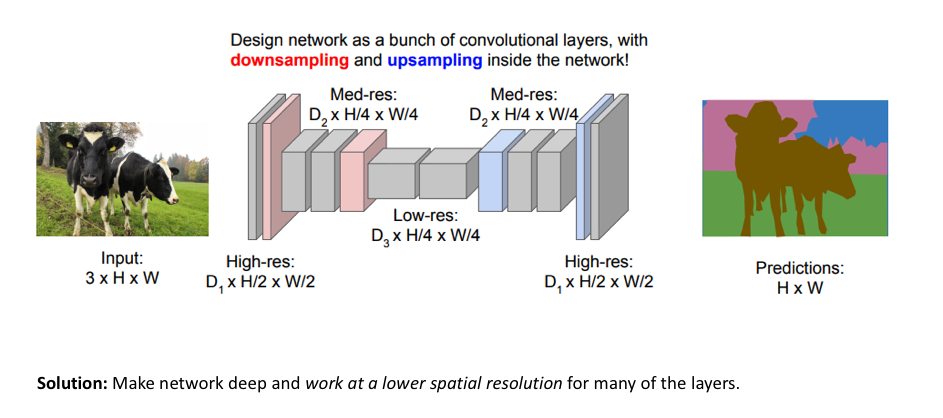

## Métodos para upsampling:

Existem algumas abordagens diferentes que podemos usar para aumentar a resolução de um mapa de recursos. Enquanto as operações de agrupamento diminuem a resolução ao resumir uma área local com um único valor (ou seja, agrupamento médio ou máximo), as operações de "unpooling" aumentam a resolução distribuindo um único valor em uma resolução mais alta.

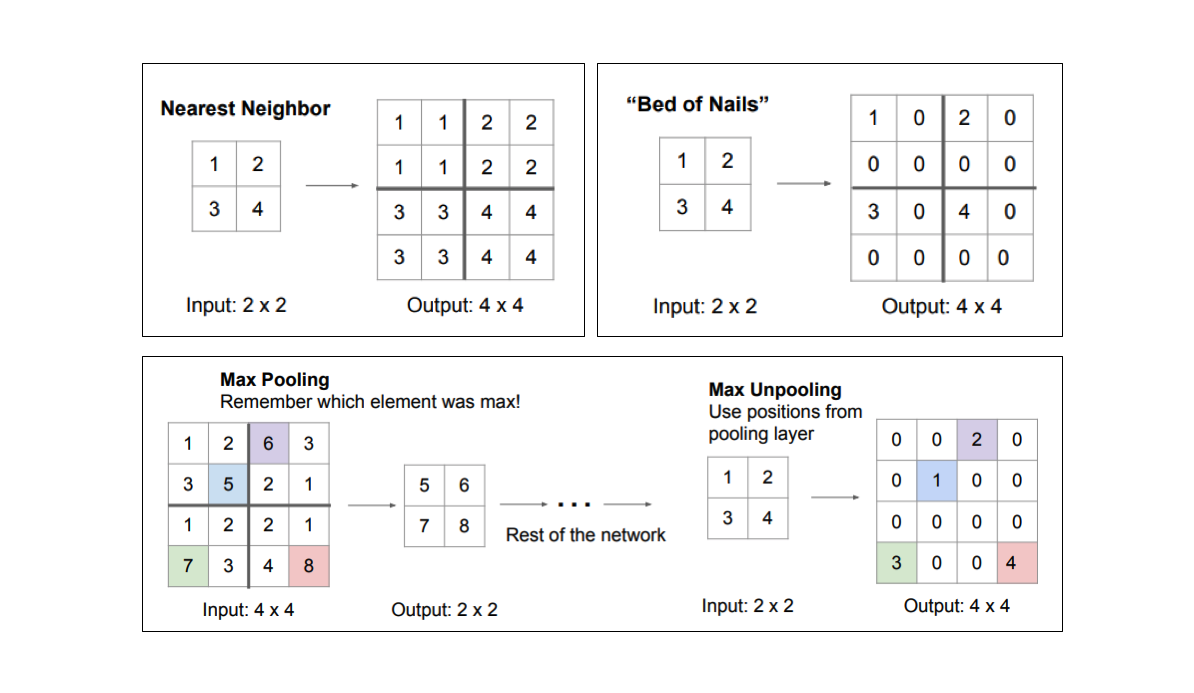

No entanto, as convoluções transpostas são de longe a abordagem mais popular, pois nos permitem desenvolver um upsampling aprendido.

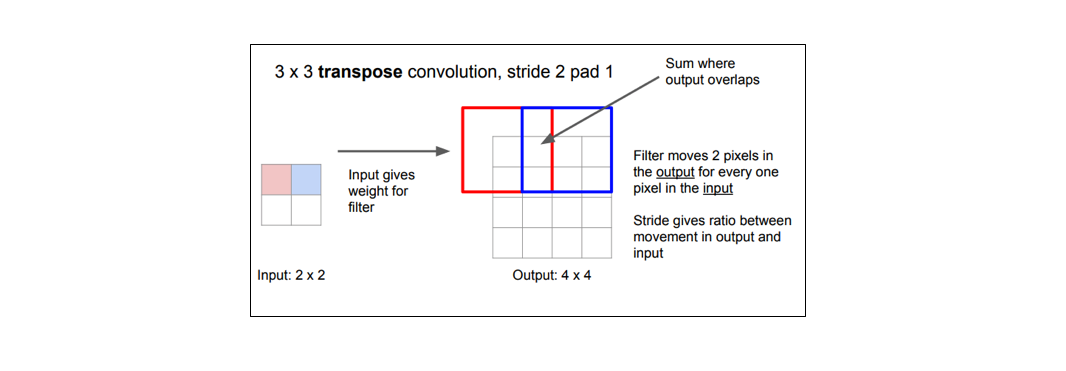

Considerando que uma operação de convolução típica tomará o produto escalar dos valores atualmente na exibição do filtro e produzirá um único valor para a posição de saída correspondente, uma convolução de transposição essencialmente faz o oposto. Para uma convolução de transposição, pegamos um único valor do mapa de recursos de baixa resolução e multiplicamos todos os pesos em nosso filtro por esse valor, projetando esses valores ponderados no mapa de recursos de saída.

Para tamanhos de filtro que produzem uma sobreposição no mapa de recursos de saída (por exemplo, filtro 3x3 com passo 2 - conforme mostrado no exemplo abaixo), os valores sobrepostos são simplesmente somados. Infelizmente, isso tende a produzir um artefato quadriculado na saída e é indesejável, portanto, é melhor garantir que o tamanho do filtro não produza uma sobreposição.

## Funções de Loss para Segmentação Semântica

A função de perda é usada para guiar a rede neural em direção à otimização. Vamos discutir algumas funções de perda populares para a tarefa de segmentação semântica. Os modelos de segmentação semântica geralmente usam uma função de perda de entropia categórica simples durante o treinamento. No entanto, se você estiver interessado em obter as informações granulares de uma imagem, precisará reverter para funções de perda um pouco mais avançadas.

### Loss baseada em distribuição

#### Cross Entropy Loss

A função de perda mais comumente usada para a tarefa de segmentação de imagem é uma perda de entropia cruzada pixel a pixel. Essa perda examina cada pixel individualmente, comparando as previsões de classe (vetor de pixel em profundidade) com nosso vetor de destino codificado one-hot.

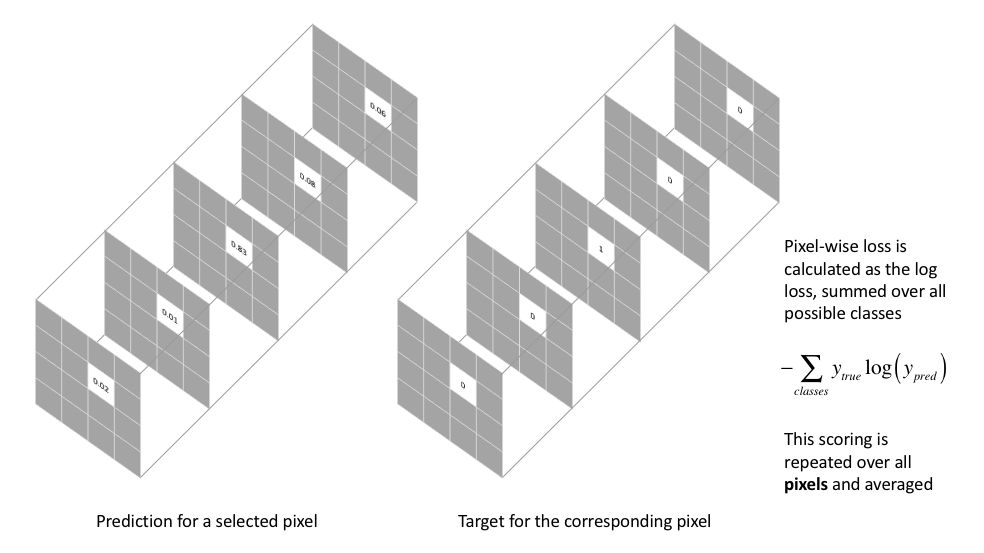

Como a perda de entropia cruzada avalia as previsões de classe para cada vetor de pixel individualmente e, em seguida, calcula a média de todos os pixels, estamos essencialmente afirmando aprendizado igual para cada pixel na imagem. Isso pode ser um problema se suas várias classes tiverem uma representação desequilibrada na imagem, pois o treinamento pode ser dominado pela classe mais prevalente. Long e outros. (documento FCN) discute a ponderação dessa perda para cada canal de saída, a fim de neutralizar um desequilíbrio de classe presente no conjunto de dados.

#### Weighted cross entropy

É uma extensão do CE, que atribui peso diferente a cada classe. Em geral, as aulas não apresentadas terão pesos maiores.

### Focal Loss

Adapta o padrão CE para lidar com desequilíbrio extremo de classes de primeiro plano e segundo plano, onde a perda atribuída a exemplos bem classificados é reduzida.

### Loss baseadas em Regiões

As funções de perda baseadas em região visam minimizar a incompatibilidade ou maximizar as regiões de sobreposição entre a ground-truth e a segmentação prevista.

### Dice Loss

A função de Dice nada mais é do que a pontuação F1. Esta função de perda tenta diretamente otimizar a pontuação F1. Da mesma forma, a pontuação IOU direta também pode ser usada para executar a otimização

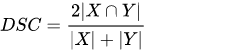

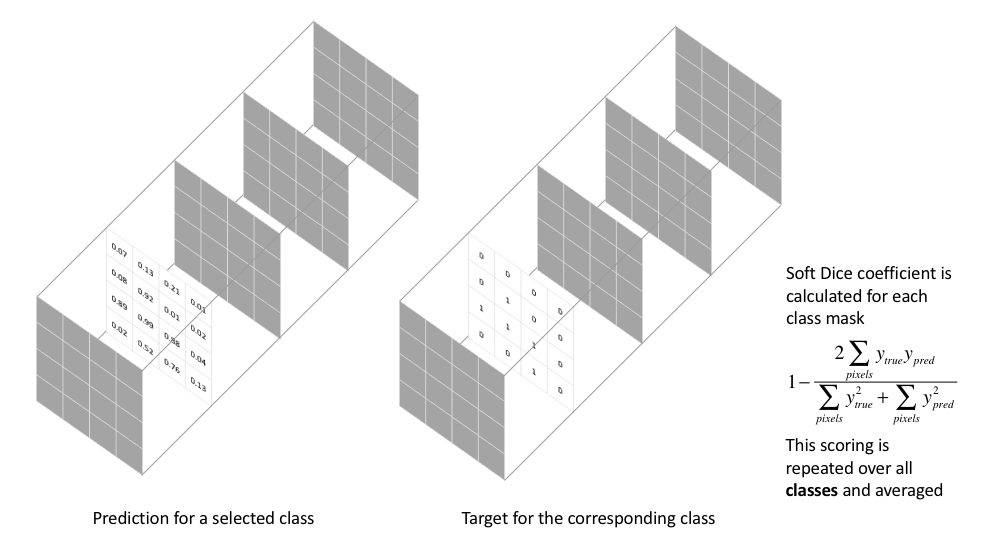

### IoU Loss

A IoU Loss (também chamada de Loss de Jaccard), semelhante à Dice Loss, também é usada para otimizar diretamente a métrica de segmentação.

#### Tversky loss

Define pesos diferentes para falso negativo (FN) e falso positivo (FP), o que é diferente da perda de dados usando pesos iguais para FN e FP.

#### Focal Tversky loss

Aplica o conceito de perda focal para focar em casos difíceis com baixas probabilidades.

## Metricas para Segmentação Semântica

Vamos discutir as métricas que geralmente são usadas para entender e avaliar os resultados de um modelo.

### Pixel Accuracy

A Acurácia de pixels é a métrica mais básica que pode ser usada para validar os resultados. A Acurácia é obtida tomando a proporção de pixels corretamente classificados em relação ao total de pixels

Acurácia = (TP+TN)/(TP+TN+FP+FN)

A principal desvantagem de usar essa técnica é que o resultado pode parecer bom se uma classe dominar a outra. Digamos, por exemplo, que a classe de plano de fundo cobre 90% da imagem de entrada, podemos obter uma precisão de 90% apenas classificando cada pixel como plano de fundo

### Métricas que baseada em IoU

Intuitivamente, uma previsão bem-sucedida é aquela que maximiza a sobreposição entre os objetos previstos e verdadeiros. Duas métricas relacionadas, mas diferentes, para esse objetivo são os coeficientes (ou índices) de Dice e Jaccard:

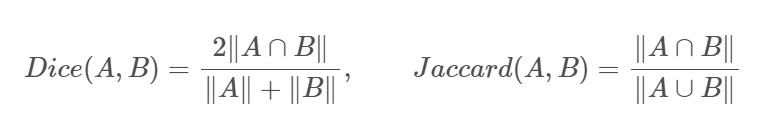

IOU é definido como a proporção da interseção da verdade absoluta e das saídas de segmentação previstas sobre sua união. Se estivermos calculando para várias classes, o IOU de cada classe é calculado e sua média é obtida. É uma métrica melhor comparada à precisão de pixel, pois se cada pixel for fornecido como plano de fundo em uma entrada de 2 classes, o valor IOU é (90/100+0/100)/2, ou seja, 45% IOU, o que fornece uma representação melhor em comparação com 90 % precisão.

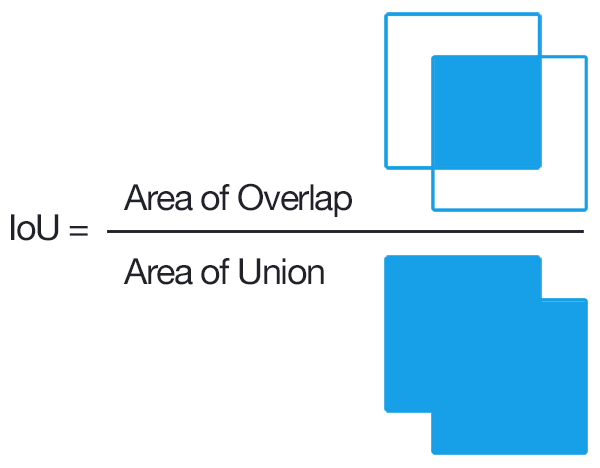

Em termos da matriz de confusão, as métricas podem ser reformuladas em termos de verdadeiros/falsos positivos/negativos:

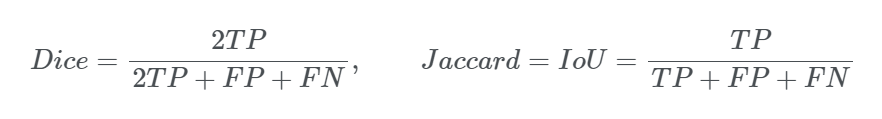

Aqui está uma ilustração das métricas Dice e IoU dados dois círculos que representam a verdade básica e as máscaras previstas para uma classe de objeto arbitrária:

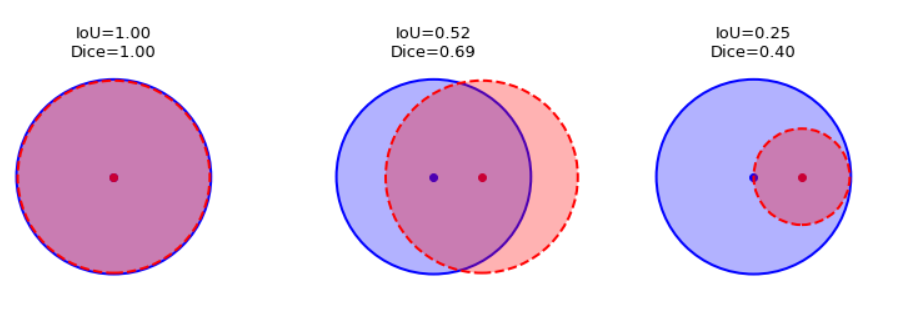

### Frequency weighted IOU

Esta é uma extensão sobre IOU média que discutimos e é usada para combater o desequilíbrio de classe. Se uma classe domina a maior parte das imagens em um conjunto de dados como, por exemplo, fundo, ela precisa ser ponderada em comparação com outras classes. Assim, em vez de obter a média de todos os resultados da classe, uma média ponderada é obtida com base na frequência da região da classe no conjunto de dados.

## FCN - Fully Convolutional Networks

A arquitetura geral de uma CNN consiste em poucas camadas convolucionais e de agrupamento seguidas por algumas camadas totalmente conectadas no final. O artigo da Fully Convolutional Network lançado em 2014 argumenta que a camada final totalmente conectada pode ser pensada como fazendo uma convolução 1x1 que cobre toda a região.

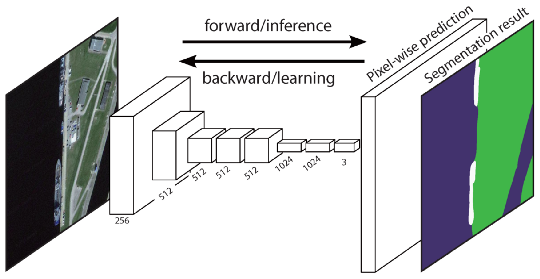

Assim, as camadas densas finais podem ser substituídas por uma camada de convolução alcançando o mesmo resultado. Mas agora a vantagem de fazer isso é que o tamanho da entrada não precisa mais ser corrigido. Ao envolver camadas densas, o tamanho da entrada é restrito e, portanto, quando uma entrada de tamanho diferente deve ser fornecida, ela deve ser redimensionada. Mas ao substituir uma camada densa por convolução, essa restrição não existe.

Além disso, quando um tamanho maior de imagem é fornecido como entrada, a saída produzida será um mapa de recursos e não apenas uma saída de classe como para uma imagem de tamanho de entrada normal. Além disso, o comportamento observado do mapa de recursos final representa o mapa de calor da classe necessária, ou seja, a posição do objeto é destacada no mapa de recursos. Como a saída do mapa de recursos é um mapa de calor do objeto necessário, é uma informação válida para nosso caso de uso de segmentação.

Uma vez que o mapa de recursos obtido na camada de saída é uma amostra reduzida devido ao conjunto de convoluções realizadas, gostaríamos de aumentar a amostra usando uma técnica de interpolação. A amostragem ascendente bilinear funciona, mas o artigo propõe o uso de amostragem aprendida com deconvolução, que pode até aprender uma amostragem ascendente não linear.

A parte de amostragem reduzida da rede é chamada de codificador e a parte de amostragem ascendente é chamada de decodificador. Esse é um padrão que veremos em muitas arquiteturas, ou seja, reduzir o tamanho com o codificador e, em seguida, aumentar a amostragem com o decodificador. Em um mundo ideal, não desejaríamos reduzir a amostra usando agrupamento e manter o mesmo tamanho, mas isso levaria a uma enorme quantidade de parâmetros e seria computacionalmente inviável.

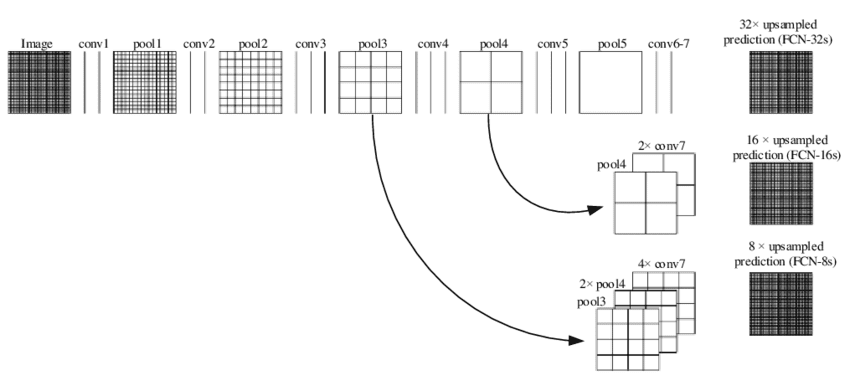

Embora os resultados de saída obtidos tenham sido decentes, a saída observada é grosseira e não suave. A razão para isso é a perda de informações na camada de feição final devido ao downsampling de 32 vezes usando camadas de convolução. Agora fica muito difícil para a rede fazer upsampling de 32x usando essas poucas informações. Essa arquitetura é chamada de FCN-32

Para resolver esse problema, o artigo propôs 2 outras arquiteturas FCN-16, FCN-8. No FCN-16, as informações da camada de agrupamento anterior são usadas junto com o mapa de recursos final e, portanto, agora a tarefa da rede é aprender a amostragem de 16x, o que é melhor em comparação com o FCN-32. O FCN-8 tenta torná-lo ainda melhor, incluindo informações de mais uma camada de pooling anterior.

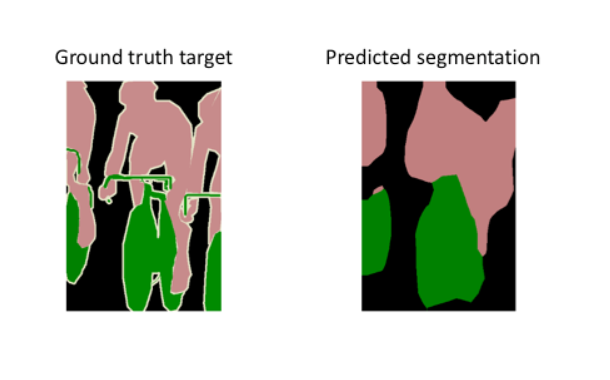

## Caso de Uso: Segmentação de classes de Uso e Cobertura

Vamos começar com um exemplo usando o conjunto de dados Landcover AI:

O conjunto de dados LandCover.ai (Land Cover from Aerial Imagery) é um conjunto de dados para mapeamento automático de edifícios, bosques, água e estradas a partir de imagens aéreas.

Recursos do conjunto de dados

- cobertura da terra da Polônia, Europa Central 1
- três bandas espectrais - RGB
- 33 ortofotos com resolução de 25 cm por pixel (~9000x9500 px)
- 8 ortofotos com resolução de 50 cm por pixel (~4200x4700 px)
- área total de 216,27 km2

Formato do conjunto de dados

- rasters são GeoTiffs de três canais com sistema de referência espacial EPSG:2180
- as máscaras são GeoTiffs de canal único com sistema de referência espacial EPSG:2180

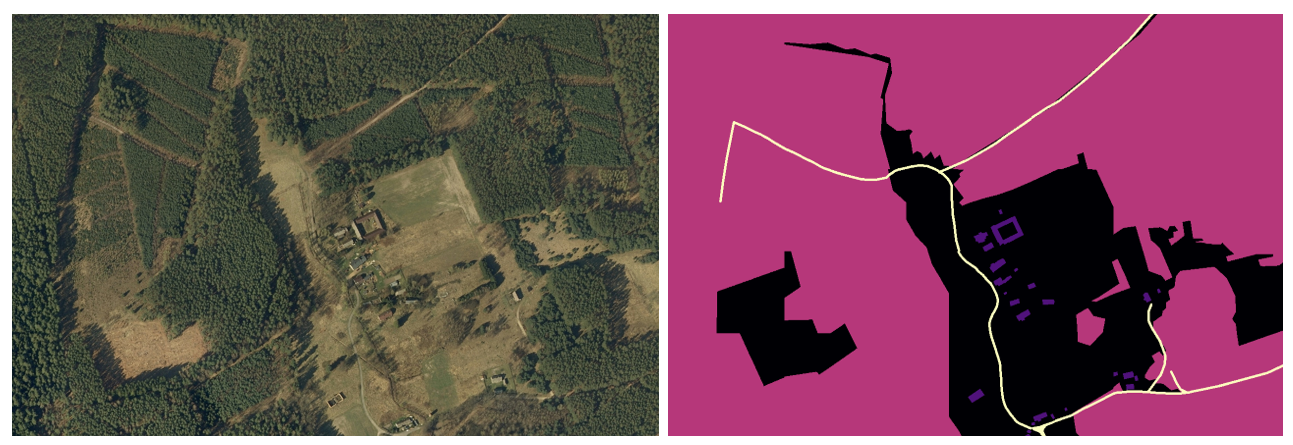

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Os mosaicos são armazenados no Drive. O primeiro passo é dividi-los em patches de 512x512 pixels

In [ ]:
IMGS_DIR = "drive/MyDrive/Datasets/Landcover_AI/images"
MASKS_DIR = "drive/MyDrive/Datasets/Landcover_AI/masks"
OUTPUT_DIR = "./output"
TARGET_SIZE = 1024

img_paths = glob.glob(os.path.join(IMGS_DIR, "*.tif"))
mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))

img_paths.sort()
mask_paths.sort()

os.makedirs(OUTPUT_DIR)
for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    mask = mask[:,:,0]
    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

    k = 0
    for y in range(0, img.shape[0], TARGET_SIZE):
        for x in range(0, img.shape[1], TARGET_SIZE):
            img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

            if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                out_img_path = os.path.join(OUTPUT_DIR, "{}_{}.jpg".format(img_filename, k))
                cv2.imwrite(out_img_path, img_tile)

                out_mask_path = os.path.join(OUTPUT_DIR, "{}_{}_m.png".format(mask_filename, k))
                cv2.imwrite(out_mask_path, mask_tile)


            k += 1

    print("Processed {} {}/{}".format(img_filename, i + 1, len(img_paths)))

Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A-c-1-3 31/41
Processed N-

Os patches foram criados e armazenados em uma pasta no armazenamento do Colab. Lembre-se de que, quando a sessão terminar, esses dados serão perdidos.

In [ ]:
path = '/content/output'

Vamos então importar as imagens e suas respectivas máscaras e convertê-las em arrays numpy:

In [ ]:
list_img = [f for f in os.listdir(path) if f.endswith('.jpg')]

In [ ]:
X = []
Y = []
NCLASSES = 5
for path_img in list_img:
  full_path = os.path.join(path, path_img)
  img = cv2.imread(full_path)
  img = cv2.resize(img, (256,256))
  id_img = path_img.split('.')[0]
  mask_id = id_img + '_m.png'
  mask_path = os.path.join(path, mask_id)
  mask = cv2.imread(mask_path)
  mask = cv2.resize(mask, (256,256))
  mask = mask[:,:,0]
  mask = np_utils.to_categorical(mask,NCLASSES)
  X.append(img)
  Y.append(mask)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape

(2513, 256, 256, 3)

Assim, podemos plotar um exemplo de uma imagem e sua máscara:

(-0.5, 255.5, 255.5, -0.5)

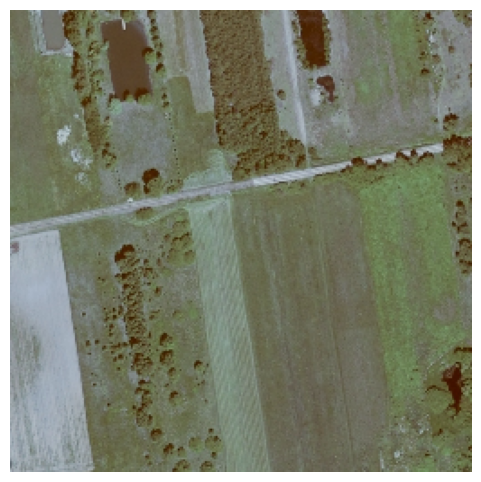

In [ ]:
plt.figure(figsize=[6,6])
plt.imshow(X[100])
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

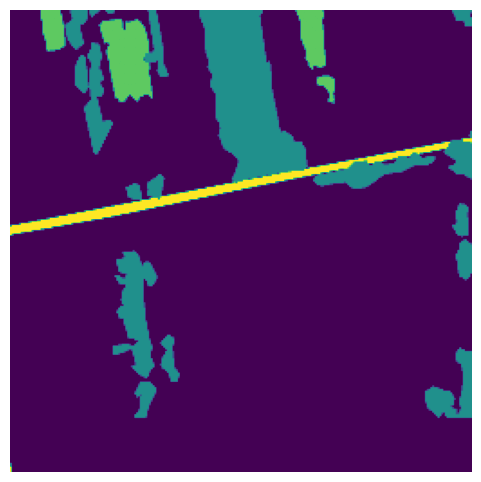

In [ ]:
plt.figure(figsize=[6,6])
plt.imshow(np.argmax(Y[100], axis=2))
plt.axis('off')

Agora é a hora de dividir os dados em treinamento e teste, redimensionar os valores para um intervalo de 0 a 1:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [ ]:
del X, Y

In [ ]:
del list_img

In [ ]:
x_train = x_train/255

A próxima etapa é importar algumas funções keras e tensorflow para a implementação da FCN:

In [ ]:
from keras.models import Model
from keras.regularizers import l2
from keras.layers import *
from keras.models import *
import keras.backend as K
import tensorflow as tf
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

Esta célula cria a operação BilinearUpsampling2D que será utilizada na parte final da arquitetura FCN:

In [ ]:
def resize_images_bilinear(X, height_factor=1, width_factor=1, target_height=None, target_width=None, data_format='default'):
    '''Resizes the images contained in a 4D tensor of shape
    - [batch, channels, height, width] (for 'channels_first' data_format)
    - [batch, height, width, channels] (for 'channels_last' data_format)
    by a factor of (height_factor, width_factor). Both factors should be
    positive integers.
    '''
    if data_format == 'default':
        data_format = K.image_data_format()
    if data_format == 'channels_first':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[2:]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = permute_dimensions(X, [0, 2, 3, 1])
        X = tf.image.resize_bilinear(X, new_shape)
        X = permute_dimensions(X, [0, 3, 1, 2])
        if target_height and target_width:
            X.set_shape((None, None, target_height, target_width))
        else:
            X.set_shape((None, None, original_shape[2] * height_factor, original_shape[3] * width_factor))
        return X
    elif data_format == 'channels_last':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[1:3]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = tf.compat.v1.image.resize_bilinear(X, new_shape)
        if target_height and target_width:
            X.set_shape((None, target_height, target_width, None))
        else:
            X.set_shape((None, original_shape[1] * height_factor, original_shape[2] * width_factor, None))
        return X
    else:
        raise Exception('Invalid data_format: ' + data_format)

class BilinearUpSampling2D(Layer):
    def __init__(self, size=(1, 1), target_size=None, data_format='default', **kwargs):
        if data_format == 'default':
            data_format = K.image_data_format()
        self.size = tuple(size)
        if target_size is not None:
            self.target_size = tuple(target_size)
        else:
            self.target_size = None
        assert data_format in {'channels_last', 'channels_first'}, 'data_format must be in {tf, th}'
        self.data_format = data_format
        self.input_spec = [InputSpec(ndim=4)]
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            width = int(self.size[0] * input_shape[2] if input_shape[2] is not None else None)
            height = int(self.size[1] * input_shape[3] if input_shape[3] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    input_shape[1],
                    width,
                    height)
        elif self.data_format == 'channels_last':
            width = int(self.size[0] * input_shape[1] if input_shape[1] is not None else None)
            height = int(self.size[1] * input_shape[2] if input_shape[2] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    width,
                    height,
                    input_shape[3])
        else:
            raise Exception('Invalid data_format: ' + self.data_format)

    def call(self, x, mask=None):
        if self.target_size is not None:
            return resize_images_bilinear(x, target_height=self.target_size[0], target_width=self.target_size[1], data_format=self.data_format)
        else:
            return resize_images_bilinear(x, height_factor=self.size[0], width_factor=self.size[1], data_format=self.data_format)

    def get_config(self):
        config = {'size': self.size, 'target_size': self.target_size}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

E então podemos implementar o FCN:

In [ ]:
weight_decay = 0.
img_input = Input(shape=x_train.shape[1:])

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(weight_decay))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(weight_decay))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

# Convolutional layers transfered from fully-connected layers
x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
x = Dropout(0.5)(x)
x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
x = Dropout(0.5)(x)
#classifying layer
x = Conv2D(NCLASSES, (1, 1), kernel_initializer='he_normal', activation='softmax', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

x = BilinearUpSampling2D(size=(32, 32))(x)

model = Model(img_input, x)

In [ ]:
model.compile(optimizer=Adam(lr = 1e-5,decay=1e-6), loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(x = x_train, y= y_train, batch_size=8, epochs=100, verbose=1, shuffle=True, validation_split=0.25)

Epoch 1/100
165/165 [==============================] - 41s 177ms/step - loss: 1.0905 - accuracy: 0.5832 - val_loss: 1.0422 - val_accuracy: 0.5485
Epoch 2/100
165/165 [==============================] - 27s 161ms/step - loss: 0.9695 - accuracy: 0.5864 - val_loss: 1.0068 - val_accuracy: 0.5485
Epoch 3/100
165/165 [==============================] - 27s 161ms/step - loss: 0.8548 - accuracy: 0.6902 - val_loss: 0.8560 - val_accuracy: 0.7204
Epoch 4/100
165/165 [==============================] - 27s 161ms/step - loss: 0.7804 - accuracy: 0.7409 - val_loss: 0.7923 - val_accuracy: 0.7244
Epoch 5/100
165/165 [==============================] - 27s 163ms/step - loss: 0.7381 - accuracy: 0.7495 - val_loss: 0.7717 - val_accuracy: 0.7271
Epoch 6/100
165/165 [==============================] - 27s 161ms/step - loss: 0.7251 - accuracy: 0.7521 - val_loss: 0.7804 - val_accuracy: 0.7207
Epoch 7/100
165/165 [==============================] - 27s 161ms/step - loss: 0.7018 - accuracy: 0.7624 - val_loss: 0.7149 -

Após o treinamento, obteremos as curvas de perda e precisão:

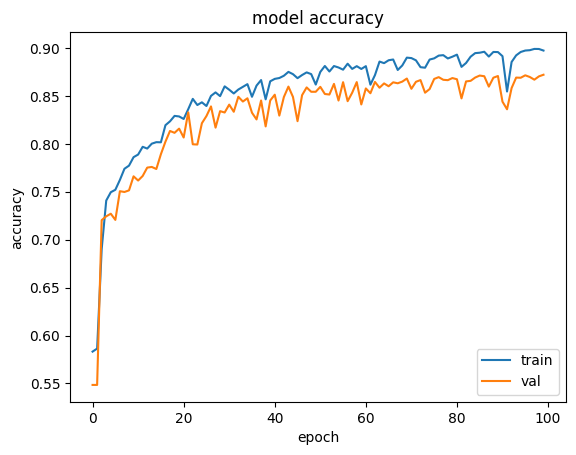

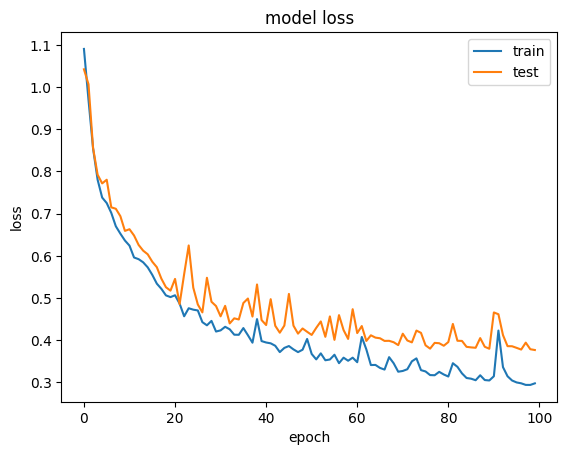

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Assim, podemos calcular a precisão para o conjunto de teste:

In [ ]:
del x_train, y_train

In [ ]:
x_test = x_test/255

In [ ]:
predict = model.predict(x_test)

24/24 [==============================] - 6s 159ms/step


In [ ]:
predict = np.round(predict)

In [ ]:
pred = np.argmax(predict, axis=3)

In [ ]:
true = np.argmax(y_test, axis=3)

In [ ]:
accuracy = accuracy_score(true.flatten(),pred.flatten())
print(accuracy)

0.8773271069918767


Por fim, vamos traçar um exemplo do resultado previsto em comparação com a máscara original:

(-0.5, 255.5, 255.5, -0.5)

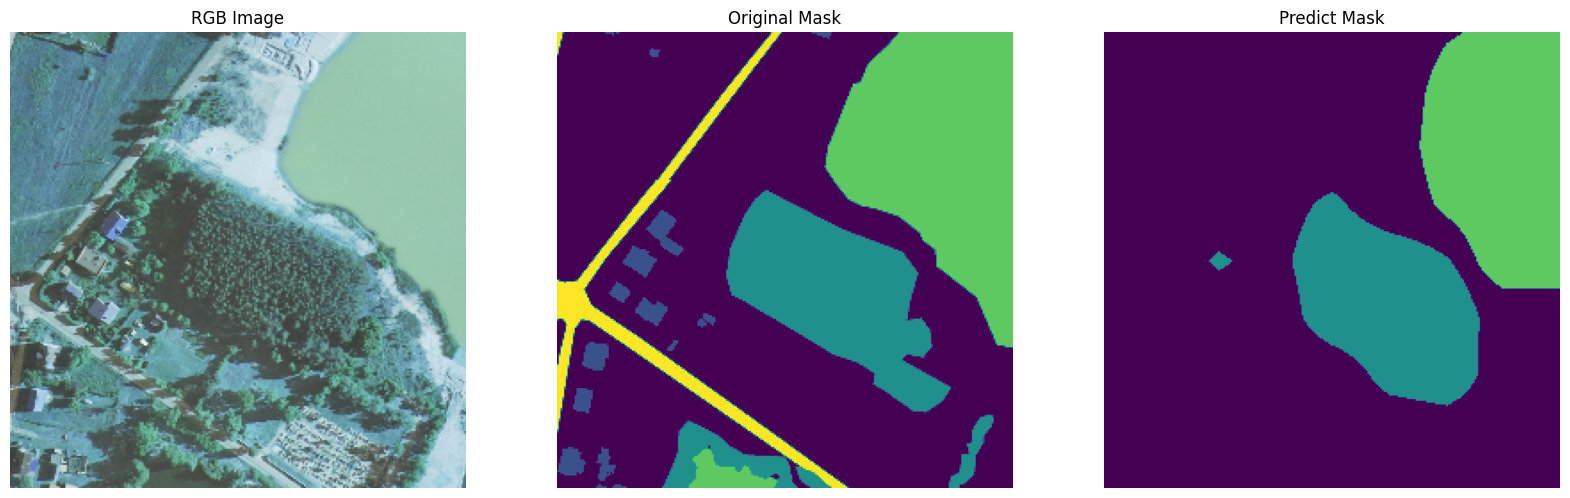

In [ ]:
i = 100
plt.figure(figsize=[20,8])
plt.subplot(131)
plt.imshow(x_test[i])
plt.title('RGB Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(true[i], vmin=0,vmax=4)
plt.title('Original Mask')
plt.axis('off')
plt.subplot(133)
plt.imshow(pred[i], vmin=0,vmax=4)
plt.title('Predict Mask')
plt.axis('off')


## SegNet

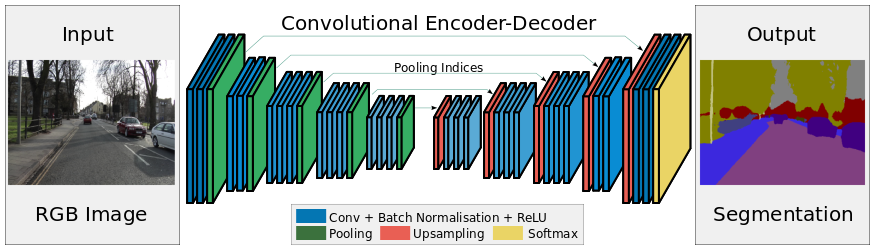

A SegNet possui uma rede codificadora e uma rede decodificadora correspondente, seguida por uma camada final de classificação pixel a pixel. Esta arquitetura é ilustrada na figura acima. A rede do codificador consiste em 13 camadas convolucionais que correspondem às primeiras 13 camadas convolucionais na rede VGG16 projetada para classificação de objetos. Eles descartam as camadas totalmente conectadas em favor da retenção de mapas de recursos de resolução mais alta na saída do codificador mais profundo. Isso também reduz significativamente o número de parâmetros na rede do codificador SegNet (de 134M para 14,7M) em comparação com outras arquiteturas recentes. Cada camada codificadora possui uma camada decodificadora correspondente e, portanto, a rede decodificadora possui 13 camadas. A saída final do decodificador é alimentada a um classificador soft-max multiclasse para produzir probabilidades de classe para cada pixel independentemente.


A rede do codificador executa a convolução com um banco de filtros para produzir um conjunto de mapas de recursos. Estes são então normalizados em lote. Em seguida, uma não linearidade linear retificada elemento a elemento (ReLU) max(0, x) é aplicada. Em seguida, o pooling máximo com uma janela 2 × 2 e passo 2 (janela não sobreposta) é executado e a saída resultante é subamostrada por um fator de 2. O pooling máximo é usado para obter invariância de translação em pequenos deslocamentos espaciais na imagem de entrada. A subamostragem resulta em um grande contexto de imagem de entrada (janela espacial) para cada pixel no mapa de recursos. Embora várias camadas de agrupamento máximo e subamostragem possam obter mais invariância de tradução para classificação robusta, correspondentemente, há uma perda de resolução espacial dos mapas de recursos. A representação de imagem cada vez mais com perdas (detalhe de contorno) não é benéfica para a segmentação onde o delineamento de contorno é vital. Portanto, é necessário capturar e armazenar informações de limite nos mapas de recursos do codificador antes de realizar a subamostragem. Se a memória durante a inferência não for restrita, todos os mapas de recursos do codificador (após a subamostragem) poderão ser armazenados. Isso geralmente não ocorre em aplicações práticas e, portanto, propomos uma maneira mais eficiente de armazenar essas informações. Envolve o armazenamento apenas dos índices de pooling máximo, ou seja, os locais do valor máximo do recurso em cada janela de pooling são memorizados para cada mapa de recursos do codificador. Em princípio, isso pode ser feito usando 2 bits para cada janela de agrupamento 2 × 2 e, portanto, é muito mais eficiente para armazenar em comparação com a memorização do(s) mapa(s) de recursos em precisão flutuante.

A rede do decodificador faz uma amostragem de seu mapa de recursos de entrada usando os índices de agrupamento máximo memorizados do(s) mapa(s) de recursos do codificador correspondente. Esta etapa produz mapa(s) de recursos esparsos. Esta técnica de decodificação SegNet é ilustrada na figura abaixo. Esses mapas de recursos são então combinados com um banco de filtro decodificador treinável para produzir mapas de recursos densos. Uma etapa de normalização em lote é então aplicada a cada um desses mapas. Observe que o decodificador correspondente ao primeiro codificador (mais próximo da imagem de entrada) produz um mapa de recursos multicanal, embora sua entrada de codificador tenha 3 canais (RGB). Isso é diferente dos outros decodificadores na rede, que produzem mapas de recursos com o mesmo número de tamanho e canais que suas entradas de codificador. A representação de característica de alta dimensão na saída do decodificador final é alimentada para um classificador soft-max treinável. Este soft-max classifica cada pixel independentemente. A saída do classificador soft-max é uma imagem do canal K de probabilidades onde K é o número de classes. A segmentação prevista corresponde à classe com probabilidade máxima em cada pixel.

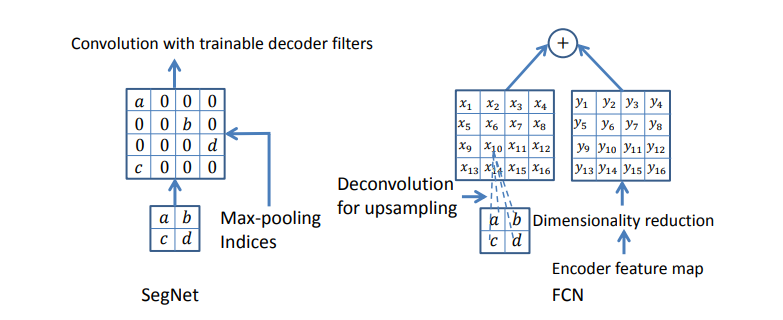

Decodificadores SegNet e FCN. a, b, c, d correspondem a valores em um mapa de recursos. A SegNet usa os índices máximos de agrupamento para aumentar a amostra (sem aprender) o mapa de recursos e convolui com um banco de filtros de decodificador treinável. FCN aumenta a amostragem aprendendo a deconvoluir o mapa de recursos de entrada e adiciona o mapa de recursos do codificador correspondente para produzir a saída do decodificador. Este mapa de recursos é a saída da camada de pool máximo (inclui subamostragem) no codificador correspondente. Observe que não há filtros decodificadores treináveis em FCN.

In [ ]:
def jaccard_coef(y_true, y_pred,smooth=100):
  # __author__ = Vladimir Iglovikov
  intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
  sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

  jac = (intersection + smooth) / (sum_ - intersection + smooth)

  return K.mean(jac)

def jaccard_loss(y_true, y_pred):
  return 1 - jaccard_coef(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

Essa é a implementação da SegNet:

In [ ]:
droprate = 0.1
pool_size = (2,2)
inputs = Input(shape=x_train.shape[1:])
conv_1 = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(inputs)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation("relu")(conv_1)
conv_1 = Dropout(droprate)(conv_1)
conv_2 = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Activation("relu")(conv_2)


pool_1 = MaxPooling2D(pool_size=pool_size)(conv_2)

conv_3 = Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same')(pool_1)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Activation("relu")(conv_3)
conv_3 = Dropout(droprate)(conv_3)
conv_4 = Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_3)
conv_4 = BatchNormalization()(conv_4)
conv_4 = Activation("relu")(conv_4)


pool_2 = MaxPooling2D(pool_size=pool_size)(conv_4)

conv_5 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(pool_2)
conv_5 = BatchNormalization()(conv_5)
conv_5 = Activation("relu")(conv_5)
conv_5 = Dropout(droprate)(conv_5)
conv_6 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_5)
conv_6 = BatchNormalization()(conv_6)
conv_6 = Activation("relu")(conv_6)
conv_6 = Dropout(droprate)(conv_6)
conv_7 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_6)
conv_7 = BatchNormalization()(conv_7)
conv_7 = Activation("relu")(conv_7)



pool_3 = MaxPooling2D(pool_size=pool_size)(conv_7)

conv_8 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(pool_3)
conv_8 = BatchNormalization()(conv_8)
conv_8 = Activation("relu")(conv_8)
conv_8 = Dropout(droprate)(conv_8)
conv_9 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_8)
conv_9 = BatchNormalization()(conv_9)
conv_9 = Activation("relu")(conv_9)
conv_9 = Dropout(droprate)(conv_9)
conv_10 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_9)
conv_10 = BatchNormalization()(conv_10)
conv_10 = Activation("relu")(conv_10)



pool_4 = MaxPooling2D(pool_size=pool_size)(conv_10)


conv_11 = Conv2D(512, (3, 3), kernel_initializer='he_uniform', padding='same')(pool_4)
conv_11 = BatchNormalization()(conv_11)
conv_11 = Activation("relu")(conv_11)
conv_11 = Dropout(droprate)(conv_11)
conv_12 = Conv2D(512, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_11)
conv_12 = BatchNormalization()(conv_12)
conv_12 = Activation("relu")(conv_12)
conv_12 = Dropout(droprate)(conv_12)
conv_13 = Conv2D(512, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_12)
conv_13 = BatchNormalization()(conv_13)
conv_13 = Activation("relu")(conv_13)

pool_5 = MaxPooling2D(pool_size=pool_size)(conv_13)

unpool_1 = UpSampling2D(size=pool_size)(pool_5)

conv_14 = Conv2D(512, (3, 3), kernel_initializer='he_uniform', padding='same')(unpool_1)
conv_14 = BatchNormalization()(conv_14)
conv_14 = Activation("relu")(conv_14)
conv_14 = Dropout(droprate)(conv_14)
conv_15 = Conv2D(512, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_14)
conv_15 = BatchNormalization()(conv_15)
conv_15 = Activation("relu")(conv_15)
conv_15 = Dropout(droprate)(conv_15)
conv_16 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_15)
conv_16 = BatchNormalization()(conv_16)
conv_16 = Activation("relu")(conv_16)

unpool_2 = UpSampling2D(size=pool_size)(conv_16)

conv_17 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(unpool_2)
conv_17 = BatchNormalization()(conv_17)
conv_17 = Activation("relu")(conv_17)
conv_17 = Dropout(droprate)(conv_17)
conv_18 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_17)
conv_18 = BatchNormalization()(conv_18)
conv_18 = Activation("relu")(conv_18)
conv_18 = Dropout(droprate)(conv_18)
conv_19 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_18)
conv_19 = BatchNormalization()(conv_19)
conv_19 = Activation("relu")(conv_19)

unpool_3 = UpSampling2D(size=pool_size)(conv_19)


conv_20 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(unpool_3)
conv_20 = BatchNormalization()(conv_20)
conv_20 = Activation("relu")(conv_20)
conv_20 = Dropout(droprate)(conv_20)
conv_21 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_20)
conv_21 = BatchNormalization()(conv_21)
conv_21 = Activation("relu")(conv_21)
conv_21 = Dropout(droprate)(conv_21)
conv_22 = Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_21)
conv_22 = BatchNormalization()(conv_22)
conv_22 = Activation("relu")(conv_22)


unpool_4 = UpSampling2D(size=pool_size)(conv_22)


conv_23 = Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same')(unpool_4)
conv_23 = BatchNormalization()(conv_23)
conv_23 = Activation("relu")(conv_23)
conv_23 = Dropout(droprate)(conv_23)
conv_24 = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(conv_23)
conv_24 = BatchNormalization()(conv_24)
conv_24 = Activation("relu")(conv_24)


unpool_5 = UpSampling2D(size=pool_size)(conv_24)


conv_25 = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(unpool_5)
conv_25 = BatchNormalization()(conv_25)
conv_25 = Activation("relu")(conv_25)

conv_26 = Conv2D(NCLASSES, (1, 1), kernel_initializer='he_uniform', padding='same')(conv_25)
conv_26 = BatchNormalization()(conv_26)
outputs = Activation("softmax")(conv_26)


model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(lr = 1e-5,decay=1e-6), loss = jaccard_loss, metrics=[jaccard_coef, 'accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_26 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_26 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_27 (Batc (None, 224, 224, 32)      128 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Referencias:

https://nanonets.com/blog/how-to-do-semantic-segmentation-using-deep-learning/

https://nanonets.com/blog/semantic-image-segmentation-2020/

https://www.jeremyjordan.me/semantic-segmentation/

https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1

https://www.meetshah.dev/semantic-segmentation/deep-learning/pytorch/visdom/2017/06/01/semantic-segmentation-over-the-years.html

http://ronny.rest/tutorials/module/seg_01/segmentation_04_training/

https://github.com/ykamikawa/tf-keras-SegNet/blob/master/model.py

https://ai-pool.com/m/segnet-1555409707

https://medium.com/analytics-vidhya/semantic-segmentation-in-pspnet-with-implementation-in-keras-4843d05fc025

https://www.kaggle.com/santhalnr/cityscapes-image-segmentation-pspnet

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html